*Below is the notebook I used to give a talk for the Triangle, NC PyData meetup on 1/6/2021.  The talk was entitled: "Insights from the human visual system: Lateral inhibition implemented in Python."*  

# 2d puppies

## setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import color, io
from scipy.signal import spline_filter
from scipy.ndimage import convolve
from matplotlib.colors import Normalize

In [2]:
def load_grayscale_image(filepath):
    return color.rgb2gray(io.imread(filepath))

In [3]:
def show_image(img):
    # higher number = higher luminance
    plt.imshow(img,cmap="gist_gray")
    plt.xticks([])
    plt.yticks([])

In [4]:
def compare_images(listofimgs,figsize=(7,7)):
    plt.figure(figsize=figsize)
    for i, img in enumerate(listofimgs):
        plt.subplot(1,len(listofimgs),i+1)
        show_image(img)
    plt.show()

In [5]:
def blurrify(img,lmbda=10000):
    return spline_filter(img,lmbda=lmbda)

In [6]:
def never_negative(img):
    return np.where(img > 0, img, 0)

In [7]:
def lateral_inhibition2d(img,c,mode="nearest",cval=0.0):
    kernel = np.array([
        [-c] * 3,
        [-c, 1, -c],
        [-c] * 3
    ])
    return never_negative(convolve(img,kernel,mode=mode,cval=cval))

In [8]:
def iterated_lateral_inhibition2d(img,c = .12,nIter = 4):
    for _ in range(nIter):
        img = lateral_inhibition2d(img,c=c)
    return img

## Reconstructing edges in a blurry image using lateral inhibition

**For an image to appear on your retina, light reflected off a real-world object has to pass through the vitreous humor in your eye.  As a result, the image that appears on your retina is distorted, like the beam of a flashlight in a swimming pool.**

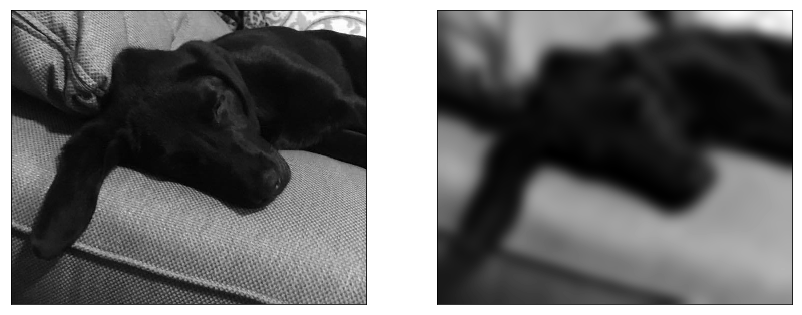

In [9]:
jones = load_grayscale_image("jonesy.png")
blurjones = blurrify(jones)
compare_images([jones,blurjones],figsize=(14,14))

**In the human visual system (as well as the horseshoe crab visual system, as well as many other visual systems...), we can correct for this distortion using lateral inhibition.**

**In a computational model, we can represent lateral inhibition by convolving the luminances in the image with the kernel below.**

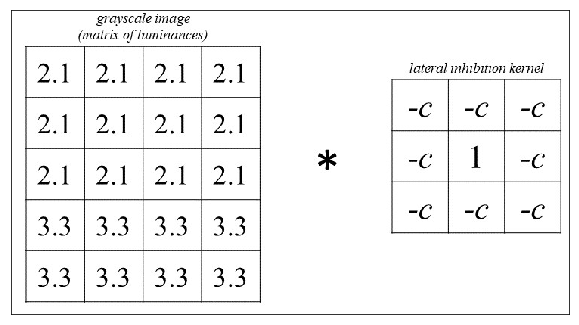

In [10]:
plt.figure(figsize=(10,10))
show_image(load_grayscale_image("lislidecropped.png"))

**Although neurons can both excite and inhibit each other using different kinds of neurotransmitters, the output we're looking at is excitatory - specifically, we're looking for how much excitation is DECREASED in the post-synaptic neuron.  Excitation can't go below zero.  So in addition to this convolution step, we replace negative values with 0.**
***
**The result is an overall decrease in luminance, but an increase in contrast - that is, where different values of luminance abut each other, the border on the dark side will get darker, and the border on the light side will get lighter.** 

**(We'll return briefly to the decrease in luminance later.)**

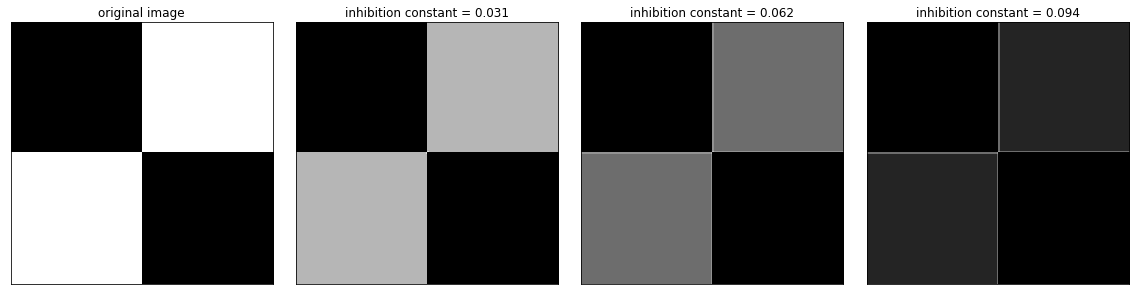

In [12]:
grid = np.array([[0] * 100 + [7] * 100] * 100 + [[7] * 100 + [0] * 100] * 100)

norm = Normalize(0,7)

constants = np.linspace(0,0.15625,6)

plt.figure(figsize=(16,4))
for i, c in enumerate(constants[:4]):
    plt.subplot(1,4,i+1)
    if c == 0:
        plt.title("original image")
    else:
        plt.title("inhibition constant = " + str(round(c,3)))
    plt.imshow(lateral_inhibition2d(grid,c),cmap="gist_gray",norm=norm)
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

**How do we tune the inhibition constant?  That is, how much should neighboring neurons want to sabotage each other?**

**We can identify an upper limit at 0.125 because...**

In [13]:
images = {
    c: lateral_inhibition2d(blurjones,c)
    for c in constants
}

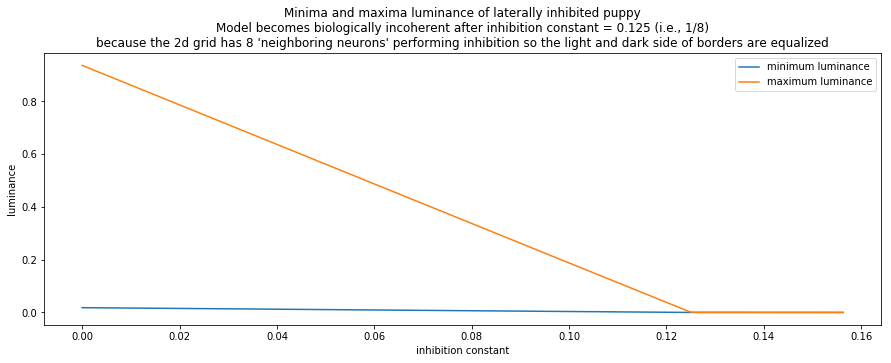

In [14]:
plt.figure(figsize=(15,5))
plt.plot(images.keys(),[v.min() for v in images.values()],label="minimum luminance")
plt.plot(images.keys(),[v.max() for v in images.values()],label="maximum luminance")
plt.xlabel("inhibition constant")
plt.ylabel("luminance")
plt.legend()
plt.title("Minima and maxima luminance of laterally inhibited puppy\nModel becomes biologically incoherent after inhibition constant = 0.125 (i.e., 1/8)\nbecause the 2d grid has 8 'neighboring neurons' performing inhibition so the light and dark side of borders are equalized")
# Essentially, in 2d lateral inhibition, any inhibition constant greater than 0.125 would give us some scaled version of the photo-negative.
plt.show()

**Once the contrast at the edges of the image are highlighted, there's an additional step - amplification of a signal, one of the most common motifs in the nervous system.  We can represent this as linearly scaling up the level of excitation.  For the remainder of this part of the demo, we can take advantage of the autoscaling default in Matplotlib.**
***
*Why not decide the scaling constant now - in particular, why not figure out what the scaling constant would need to be to get it close to the original image?  Because it's not actually necessary for us to scale the image back up to the original luminance levels - because while neural representations have to be useful for the rest of our nervous system, they don't have to be veridical.  As a result, we can assume that there is some constant we scale the luminance of the image up by, and for demonstration purposes, we'll just let Matplotlib make it minmax scaled.*

**Now that we have a convolved, negatives-become-zeroed, amplified image, we can see that not much seems to happen as we increase the inhibition constant until we get to the equalized inhibition constant of 0.125 (or 1/8).  Any changes are really subtle.**

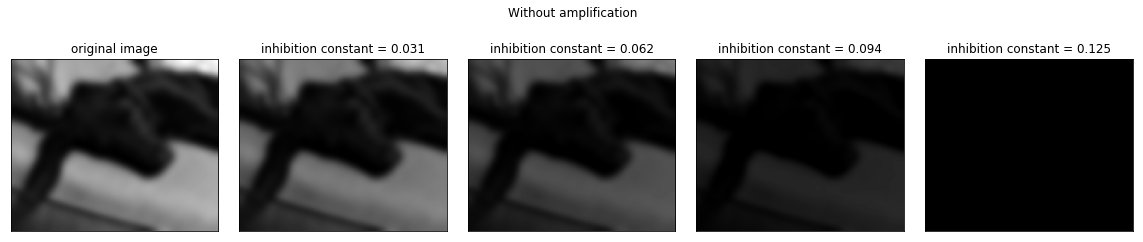

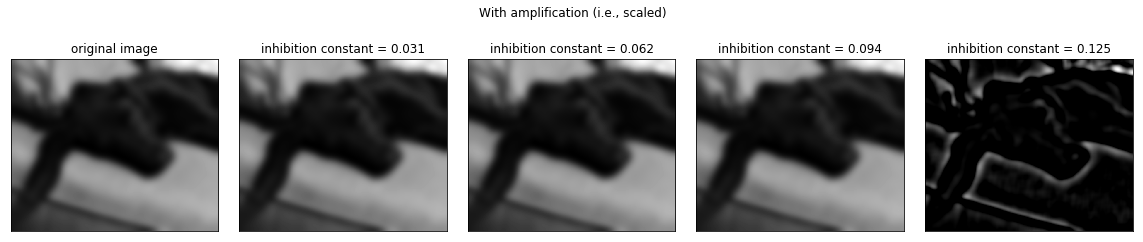

In [17]:
norm = Normalize(blurjones.min(),blurjones.max())

plt.figure(figsize=(16,4))
plt.suptitle("Without amplification")
for i, c in enumerate(constants[:5]):
    plt.subplot(1,5,i+1)
    if c == 0:
        plt.title("original image")
    else:
        plt.title("inhibition constant = " + str(round(c,3)))
    plt.imshow(lateral_inhibition2d(blurjones,c),cmap="gist_gray",norm=norm)
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

plt.figure(figsize=(16,4))
plt.suptitle("With amplification (i.e., scaled)")
for i, c in enumerate(constants[:5]):
    plt.subplot(1,5,i+1)
    if c == 0:
        plt.title("original image")
    else:
        plt.title("inhibition constant = " + str(round(c,3)))
    show_image(images[c])

plt.tight_layout()
plt.show()

**But the nervous system is made up of various layers.  Lateral inhibition isn't performed just once.**

**What happens if we iterate lateral inhibition?**

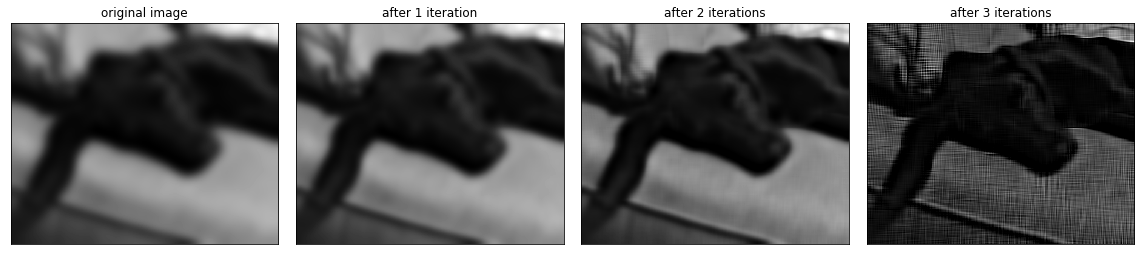

In [18]:
its = 4
c = .124

plt.figure(figsize=(16,4))
for nIter in range(its):
    plt.subplot(1,its,nIter+1)
    if nIter==0:
        plt.title("original image")
        show_image(blurjones)
    elif nIter==1:
        plt.title("after " + str(nIter) + " iteration")
        show_image(iterated_lateral_inhibition2d(blurjones,c,nIter))
    else:
        plt.title("after " + str(nIter) + " iterations")
        show_image(iterated_lateral_inhibition2d(blurjones,c,nIter))
        
plt.tight_layout()
plt.show()
        
    
    # we do see some artifact here - note that a laterally-inhibited image isn't veridical!

**Tuning the parameters for the specific problem of 'get blurry Jonesy as close as possible to unblurry Jonesy' isn't straightforward, because most cost functions I could come up with don't map neatly onto 'what looks most like a puppy.'**

**We can visually inspect a grid where we modulate the inhibition constant and number of iterations.**

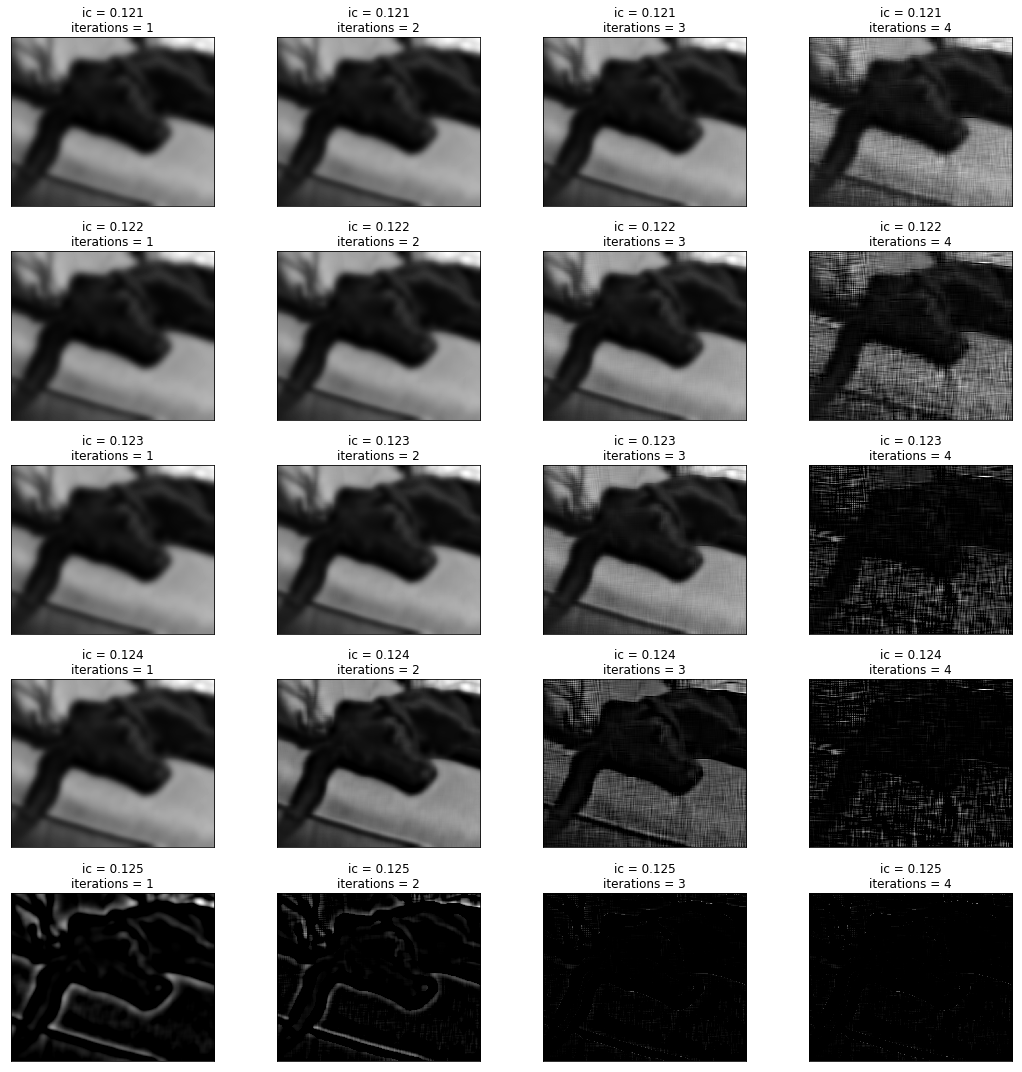

In [19]:
plt.figure(figsize=(15,15))
for i, c in enumerate(np.linspace(.121,.125,5)):
    for nIter in range(1,5):
        plotspot = 4 * i + nIter
        plt.subplot(5,4,plotspot)
        processed_puppy = iterated_lateral_inhibition2d(blurjones,c=c,nIter=nIter)
        plt.title("ic = " + str(round(c,3)) + "\niterations = " + str(nIter))
        show_image(processed_puppy)
        
plt.tight_layout()
plt.show()

**My favorite parameters:**

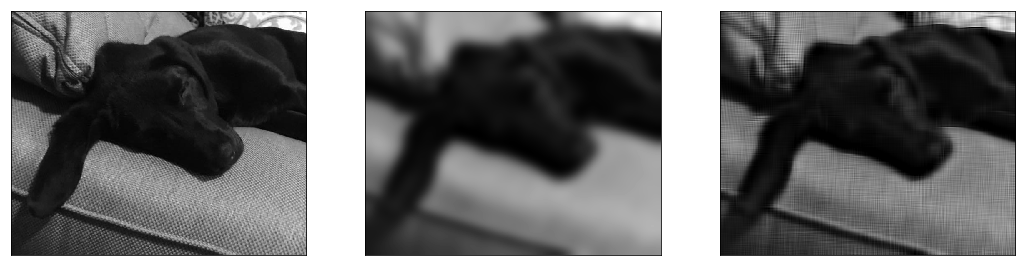

In [20]:
compare_images([jones,blurjones,iterated_lateral_inhibition2d(blurjones,c=.12352,nIter=3)],figsize=(18,18))

## Takeaways

- Lateral inhibition of a distorted image does not result in a totally veridical reconstruction of the image.  However, it "satisfices" as a shortcut to being able to identify edges well enough that it increased survival in organisms with this trait.
- We can represent lateral inhibition artificially by:
    - convolving a matrix of luminances with a kernel
    - replacing negative values in convolved matrix with zero
    - amplifying by some arbitrary(ish) constant

# 3d flowers

## setup

In [21]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.colors import Normalize

from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score

from seaborn import heatmap

from functools import reduce

from scipy.ndimage import convolve

In [22]:
def plot3d(ax,pdf,y,drop = ["petal_length"],label = None,color = None,norm = False):
    if not label:
        label = y
    if norm:
        norm = Normalize(0,1)
    ax.scatter3D(*pdf.loc[y].drop(drop,axis=1).values.T,label=label,color=color,norm=norm)

In [23]:
def make_it_sparse(pdf,precision = 2):
    
    def cross_join(pdf1,pdf2):
        pdf1["key"] = 0
        pdf2["key"] = 0
        return pdf1.merge(pdf2,on="key").drop("key",axis=1)

    features = list(pdf.columns)

    scaled_data = MinMaxScaler().fit_transform(pdf[features]) * 10 ** precision

    weighted_scaled_pdf = (
        pd.DataFrame(
            pd.DataFrame(
                data = scaled_data,
                columns = features,
                index = pdf.index
            )            
            .apply(round)
            .reset_index()
            .groupby(["index"] + features)
            [features[0]] # doesn't matter, we just want one column is all
            .count()
        )
        .rename(columns={features[0]:"weight"})
        .reset_index()
    )

    span = list(range(0,10 ** precision + 1))

    # get a big crossjoin of all the different possible space where a point could fall
    # and merge the weighted scaled pdf onto it
    # and put zeros where there's no weight
    
    output_pdf = (
        reduce(lambda x, y: cross_join(x,y), [pd.DataFrame(data=span,columns=[feature]) for feature in features])
        .merge(
            weighted_scaled_pdf,
            on=features,
            how="left"
        )
        .fillna({"weight":0})
        .astype({"weight":int})
    )
    
    return output_pdf


In [24]:
def never_negative(img):
    return np.where(img > 0, img, 0)

In [25]:
def lateral_inhibition3d(mat,c,mode="nearest",cval=0.0):
    kernel = np.ones((3,3,3)) * -c
    kernel[1][1][1] = 1
    return never_negative(convolve(mat,kernel,mode=mode,cval=cval))

In [26]:
def iterated_lateral_inhibition3d(mat,c = .038,nIter = 4):
    for _ in range(nIter):
        mat = lateral_inhibition3d(mat,c=c)
    return mat

In [27]:
def li_for_scatter3d(pdf,precision = 2,c = .038,nIter=1):
    dim = 10 ** precision + 1
    sparse_pdf = make_it_sparse(pdf,precision=precision)
    mat = sparse_pdf["weight"].div(sparse_pdf["weight"].max()).values.reshape(dim,dim,dim)
    sparse_pdf["proc_weight"] = iterated_lateral_inhibition3d(mat,c=c,nIter=nIter).flatten()
    
    return sparse_pdf

## Lateral inhibition, clusters, and classification

**A tiny amount of work has been done to investigate lateral inhibition as part of classification or clustering pipelines in multidimensional datasets (see Guo, Song, and Zeng, 2016: https://ieeexplore.ieee.org/document/7867301**

**How might lateral inhibition help us in such a problem?**

**We might try applying it to the famous iris dataset, which includes**
    - three kinds of iris: setosa, virginica, and versicolor
    - 50 observations of each kind of iris
    - four features, of which we will only look at three: sepal length, sepal width, and petal width

In [28]:
data = load_iris(return_X_y=True)

iris_pdf = (
    pd.DataFrame(
        data = data[0],
        columns = ["sepal_length","sepal_width","petal_length","petal_width"],
        index = data[1]
    )
    .rename(index={0:"setosa",1:"versicolor",2:"virginica"})
)

iris_pdf.head()

,sepal_length,sepal_width,petal_length,petal_width
setosa,5.1,3.5,1.4,0.2
setosa,4.9,3.0,1.4,0.2
setosa,4.7,3.2,1.3,0.2
setosa,4.6,3.1,1.5,0.2
setosa,5.0,3.6,1.4,0.2


**When we plot each of these three sets of 50 irises in 3-dimensional space, we see that they are clustered sort of close together.**

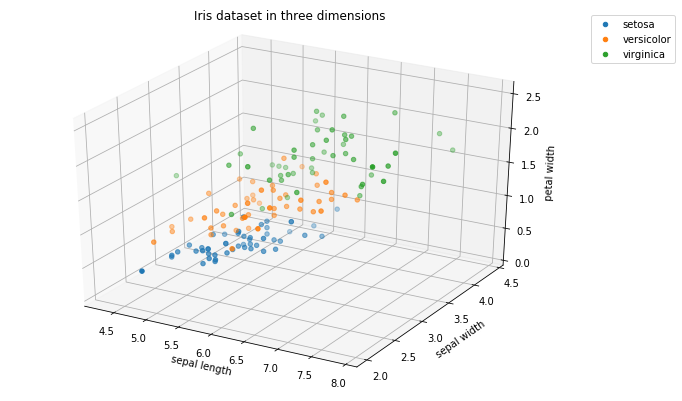

In [29]:
fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection = "3d")

plt.title("Iris dataset in three dimensions\n")

for flower in ["setosa","versicolor","virginica"]:
    plot3d(ax,iris_pdf,flower)

ax.set_xlabel("sepal length")
ax.set_ylabel("sepal width")
ax.set_zlabel("petal width")

plt.legend(bbox_to_anchor=(1.2,1))
plt.show()

**If we were botanists doing our work before the classes of 'setosa', 'virginica' and 'versicolor' had even been defined, we might use an unsupervised approach to cluster these 150 unspecified irises into three groups based on similarities in sepal length, sepal width, and petal width.**

In [30]:
kmeans = KMeans(n_clusters = 3, random_state = 2112).fit(iris_pdf.drop("petal_length",axis=1).values)
iris_pdf["cluster"] = kmeans.labels_

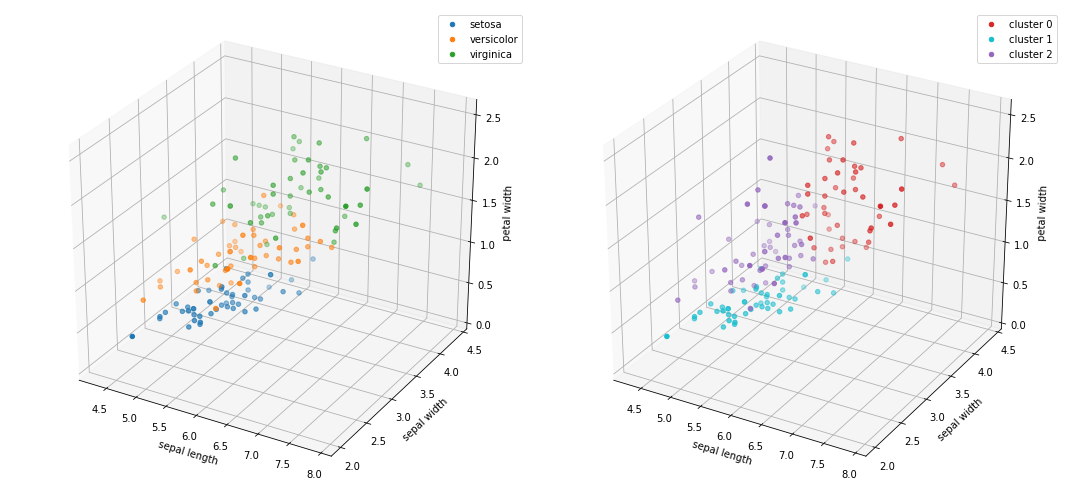

In [31]:
fig = plt.figure(figsize=(15,7))

ax1 = fig.add_subplot(1,2,1,projection="3d")
for flower in ["setosa","versicolor","virginica"]:
    plot3d(ax1,iris_pdf,flower)

ax1.set_xlabel("sepal length")
ax1.set_ylabel("sepal width")
ax1.set_zlabel("petal width")
    
plt.legend()

colors = ["tab:red","tab:cyan","tab:purple"]
ax2 = fig.add_subplot(1,2,2,projection="3d")
for k, color in enumerate(colors):
    plot3d(ax2,iris_pdf.set_index("cluster"),k,drop=["petal_length"],label="cluster " + str(k),color=color)

ax2.set_xlabel("sepal length")
ax2.set_ylabel("sepal width")
ax2.set_zlabel("petal width")

plt.legend()
plt.tight_layout()
plt.show()

**It happens to be the case that this information about the flowers - sepal width, sepal length, and petal width - provides a clustering solution that maps pretty nicely onto what the original botanical taxonomists arrived at (in other words, these different varieties of iris are pretty easily distinguished by these features).**

**In fact, we can check this in sort of a backdoor way - if you train a random forest classifier solely on which cluster any given iris was assigned to, you end up with a pretty coherent model.**

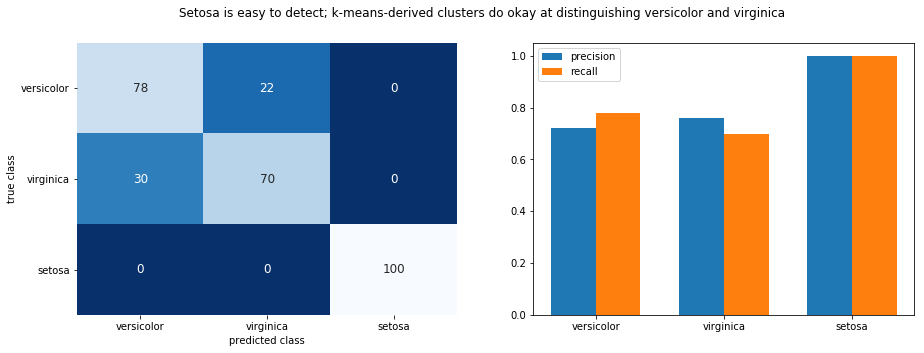

In [32]:
onehot = pd.get_dummies(iris_pdf["cluster"])

rfc = RandomForestClassifier(random_state=2112).fit(onehot.values,onehot.index)

labels = ["versicolor","virginica","setosa"]

y_true = onehot.index
y_pred = rfc.predict(onehot.values)

original_confmat = np.vectorize(round)(confusion_matrix(y_true,y_pred,labels = labels,normalize="true") * 100)

plt.figure(figsize=(15,5))
plt.suptitle("Setosa is easy to detect; k-means-derived clusters do okay at distinguishing versicolor and virginica")

plt.subplot(1,2,1)
heatmap(original_confmat,annot=True,fmt="d",annot_kws={"size":12},cmap="Blues_r",cbar=False)
plt.xticks(np.arange(len(labels))+.5,labels)
plt.yticks(np.arange(len(labels))+.5,labels,rotation=0)

plt.xlabel("predicted class")
plt.ylabel("true class")

plt.subplot(1,2,2)

original_precisions = precision_score(y_true,y_pred,labels,average=None)
original_recalls = recall_score(y_true,y_pred,labels,average=None)

w = .35
plt.bar(np.arange(len(labels)) - w/2, original_precisions, w, label = "precision")
plt.bar(np.arange(len(labels)) + w/2, original_recalls, w, label = "recall")
plt.xticks(range(len(labels)),labels)

plt.legend()

plt.show()

**Setosa is clearly very easy to detect, with perfect precision and accuracy.  Virginica and versicolor are sometimes confused for each other.  In the left-hand scatter plot above, you can see that the points for virginica and versicolor seem to overlap a little more than setosa does with either of them.**

**What if we applied lateral inhibition to this multidimensional space?  Would the contrast at the border between virginica and versicolor be highlighted?**
***
*To realize this, I represented the multidimensional space as a 3d matrix where the point at each coordinate triad was weighted by how many observations fell into that point. In other words, if no irises had a petal width of a, a sepal length of b, and a sepal width of c, then point abc in the matrix = 0.  If two irises had a petal width of d, a sepal width of e, and a sepal length of f, then point def = 2.**

*We can't use the same kernel we used for 2d lateral inhibition, because now we're in 3d.  We can generalize it to a 3 x 3 x 3 matrix of inhibition constants with a 1 in the center. Otherwise, the basic process is the same - convolve and replace negative values with zero.  Amplification was conducted just to scale for human interpretability.*

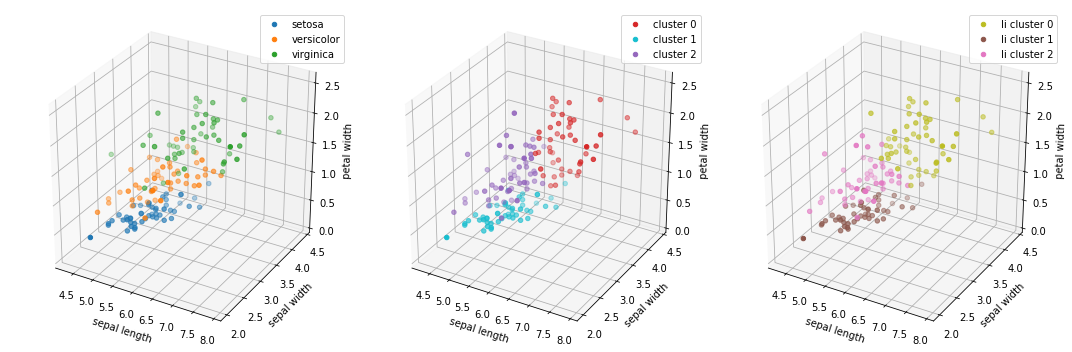

In [33]:
features = ["sepal_length","sepal_width","petal_width"]

li_scatter = li_for_scatter3d(iris_pdf[features],nIter=4)

li_scatter_trunc = li_scatter.dropna(subset=["index"]).set_index("index") # only look at original points

kmeans_li = KMeans(n_clusters = 3, random_state = 2112).fit(li_scatter_trunc[features].values,sample_weight=li_scatter_trunc["proc_weight"])
li_scatter_trunc["cluster"] = kmeans_li.labels_

for feature in features:
    oldmin, oldmax = li_scatter_trunc[feature].agg(["min","max"])
    newmin, newmax = iris_pdf[feature].agg(["min","max"])
    li_scatter_trunc[feature] = li_scatter_trunc[feature].apply(
        lambda x: ((x - oldmin) / (oldmax - oldmin)) * (newmax - newmin) + newmin
    )

fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(1,3,1,projection="3d")
for flower in ["setosa","versicolor","virginica"]:
    plot3d(ax1,iris_pdf,flower)

ax1.set_xlabel("sepal length")
ax1.set_ylabel("sepal width")
ax1.set_zlabel("petal width")    
plt.legend()

colors = ["tab:red","tab:cyan","tab:purple"]
ax2 = fig.add_subplot(1,3,2,projection="3d")
for k, color in enumerate(colors):
    plot3d(ax2,iris_pdf.set_index("cluster"),k,drop=["petal_length"],label="cluster " + str(k),color=color)

ax2.set_xlabel("sepal length")
ax2.set_ylabel("sepal width")
ax2.set_zlabel("petal width")
plt.legend()

colors = ["tab:olive","tab:brown","tab:pink"]
ax3 = fig.add_subplot(1,3,3,projection="3d")
for k, color in enumerate(colors):
    plot3d(ax3,li_scatter_trunc.set_index("cluster"),k,drop=["weight","proc_weight"],label="li cluster " + str(k),color=color)

ax3.set_xlabel("sepal length")
ax3.set_ylabel("sepal width")
ax3.set_zlabel("petal width")

plt.legend()
plt.tight_layout()
plt.show()

**Now each of the original points had a new "luminance" - that is, they were downweighted overall, but at borders between different densities/weights of points, points on the light side of the hyperplane were upweighted and vice versa.**

**I submitted the points to a kmeans cluster analysis again, but this time, I adjusted the weights based on lateral inhibition.  The results are plotted above, and they are subtle.**

**How can we tell if this adjustment in the weights of the points improve on a plain old unweighted kmeans analysis?**

**Suppose we use the new cluster labels - the ones that take into account how much weight to give any given observation based on lateral inhibition - to train a random forest classifier again.  How well would cluster membership predict the original variety of iris?**

**Modestly better than when unweighted.**

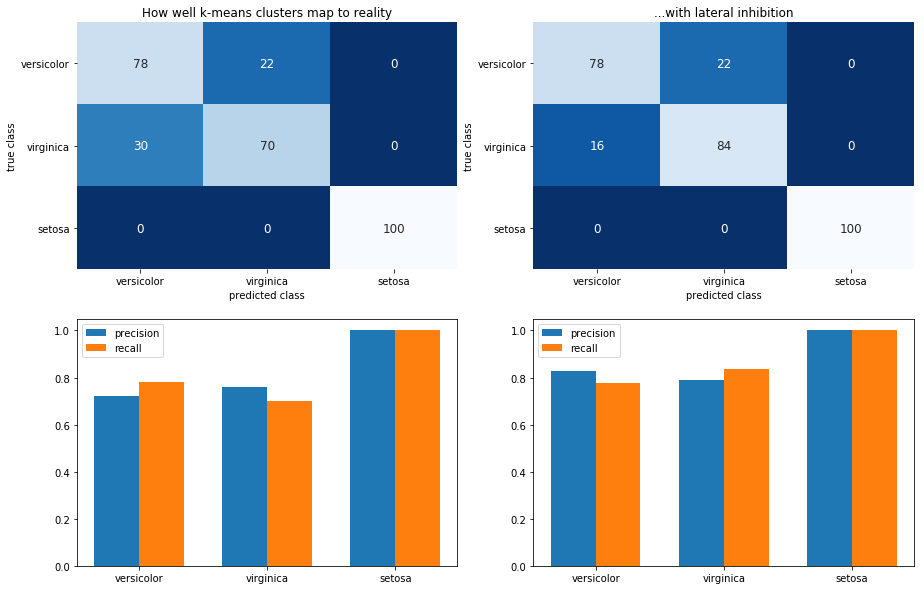

In [34]:
onehot = pd.get_dummies(li_scatter_trunc["cluster"])

rfc = RandomForestClassifier(random_state=2112).fit(onehot.values,onehot.index)

labels = ["versicolor","virginica","setosa"]

y_true = onehot.index
y_pred = rfc.predict(onehot.values)

confmat = np.vectorize(round)(confusion_matrix(y_true,y_pred,labels = labels,normalize="true") * 100)

plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.title("How well k-means clusters map to reality")
heatmap(original_confmat,annot=True,fmt="d",annot_kws={"size":12},cmap="Blues_r",cbar=False)
plt.xticks(np.arange(len(labels))+.5,labels)
plt.yticks(np.arange(len(labels))+.5,labels,rotation=0)
plt.xlabel("predicted class")
plt.ylabel("true class")

plt.subplot(2,2,2)
plt.title("...with lateral inhibition")
heatmap(confmat,annot=True,fmt="d",annot_kws={"size":12},cmap="Blues_r",cbar=False)
plt.xticks(np.arange(len(labels))+.5,labels)
plt.yticks(np.arange(len(labels))+.5,labels,rotation=0)
plt.xlabel("predicted class")
plt.ylabel("true class")

plt.subplot(2,2,3)
w = .35
plt.bar(np.arange(len(labels)) - w/2, original_precisions, w, label = "precision")
plt.bar(np.arange(len(labels)) + w/2, original_recalls, w, label = "recall")
plt.xticks(range(len(labels)),labels)

plt.legend()

plt.subplot(2,2,4)
precisions = precision_score(y_true,y_pred,labels,average=None)
recalls = recall_score(y_true,y_pred,labels,average=None)
plt.bar(np.arange(len(labels)) - w/2, precisions, w, label = "precision")
plt.bar(np.arange(len(labels)) + w/2, recalls, w, label = "recall")
plt.xticks(range(len(labels)),labels)

plt.legend()

plt.show()

## Takeaway

- Modest increase in expected direction - consistent with the idea that the configuration of the versicolor and virginica irses in multidimensional space, although overlapping, was such that we could use lateral inhibition to "sharpen the contrast" between them
    - caveat: this is more in the spirit of playful exploration and innovation than as a call to action for the specific use of this computational model for clustering problems
    
- Biology has always informed computer science!

**Feel free to get in touch!**

**Eleanor Hanna, Ph.D.**

hannae@valassis.com

**https://www.linkedin.com/in/eleanor-hanna/**